### Importing necessary libraries

In [1]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('final-kijiji-data.csv')

In [3]:
df.head()

,Unnamed: 0,Title,Address,Price Label,Price Value,Date Posted,Unit Row,Parking,Agreement Type,Air Conditioning,Description,Visits
0,0,Basement room for rent,"Tremblay St, Brampton, ON L6Z",Some Utilities Included,[],5 Days ago,NaN,NaN,1 year,NaN,DescriptionLooking for a girl to share a one b...,102 visits
1,1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,"Ajax, ON L1T",No Utilities Included,[],5 Days ago,Apartment Bedrooms: 1 Bathrooms: 1,1.0,1 year,No,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",4 visits
2,2,Modern Heritage One Bedroom,"Market Square, Napanee, ON K7R 1R3",Some Utilities Included,"['$1,750']",3 Days ago,Apartment Bedrooms: 1 Bathrooms: 1,1.0,1 year,Yes,DescriptionThis stunning Heritage 1 Bedroom Ap...,142 visits
3,3,Bachelor suite for lease,"Napanee, ON K7R 1H6",No Utilities Included,"['$1,075']",5 Days ago,Apartment Bedrooms: 2 Bathrooms: 1,1.0,6 months,No,DescriptionNice modern bachelor apartment for ...,187 visits
4,4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville","Mistletoe Gardens, Oakville, ON",NaN,[],5 Days ago,Condo Bedrooms: 2 Bathrooms: 1,1.0,1 year,No,DescriptionLovely Well-Maintained Freehold Tow...,9 visits


### Pre-Processing

In [4]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18724 entries, 0 to 18723
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             18724 non-null  object 
 1   Address           18724 non-null  object 
 2   Price Label       16335 non-null  object 
 3   Price Value       18724 non-null  object 
 4   Date Posted       18724 non-null  object 
 5   Unit Row          14744 non-null  object 
 6   Parking           14744 non-null  float64
 7   Agreement Type    17768 non-null  object 
 8   Air Conditioning  9764 non-null   object 
 9   Description       18724 non-null  object 
 10  Visits            14947 non-null  object 
dtypes: float64(1), object(10)
memory usage: 1.6+ MB


In [6]:
df.describe()

,Parking
count,14744.000000
mean,1.483587
std,0.677745
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


In [7]:
df.isnull().sum()

Title                  0
Address                0
Price Label         2389
Price Value            0
Date Posted            0
Unit Row            3980
Parking             3980
Agreement Type       956
Air Conditioning    8960
Description            0
Visits              3777
dtype: int64

In [8]:
df['Parking'] = df['Parking'].fillna(0)

In [9]:
df['Parking'].isnull().sum()

0

In [10]:
df['Price Value'] = df['Price Value'].str.replace('[^\d.]', '', regex=True).replace('', '0').astype(float)

In [11]:
df['Price Value'].head()

0       0.0
1       0.0
2    1750.0
3    1075.0
4       0.0
Name: Price Value, dtype: float64

In [12]:
df['Unit Row'].head()

0                                   NaN
1    Apartment Bedrooms: 1 Bathrooms: 1
2    Apartment Bedrooms: 1 Bathrooms: 1
3    Apartment Bedrooms: 2 Bathrooms: 1
4        Condo Bedrooms: 2 Bathrooms: 1
Name: Unit Row, dtype: object

In [13]:
df['Bedrooms'] = df['Unit Row'].str.extract(r'Bedrooms: (\d+\.\d+|\d+)', expand=False).fillna(0).astype(float)

In [14]:
df['Bedrooms'].unique()

array([0. , 1. , 2. , 3. , 2.5, 4. , 5. ])

In [15]:
df['Bathrooms'] = df['Unit Row'].str.extract(r'Bathrooms: (\d+\.\d+|\d+)', expand=False).fillna(0).astype(float)

In [16]:
df['Bathrooms'].unique()

array([0. , 1. , 1.5, 2.5, 2. , 3. , 4. ])

In [17]:
df['Unit Type'] = df['Unit Row'].str.split(' ').str.get(0).fillna('Unknown')

In [18]:
df['Unit Type'].unique()

array(['Unknown', 'Apartment', 'Condo', 'Basement', 'House', 'Triplex',
       'Townhouse'], dtype=object)

In [19]:
df.head()

,Title,Address,Price Label,Price Value,Date Posted,Unit Row,Parking,Agreement Type,Air Conditioning,Description,Visits,Bedrooms,Bathrooms,Unit Type
0,Basement room for rent,"Tremblay St, Brampton, ON L6Z",Some Utilities Included,0.0,5 Days ago,NaN,0.0,1 year,NaN,DescriptionLooking for a girl to share a one b...,102 visits,0.0,0.0,Unknown
1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,"Ajax, ON L1T",No Utilities Included,0.0,5 Days ago,Apartment Bedrooms: 1 Bathrooms: 1,1.0,1 year,No,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",4 visits,1.0,1.0,Apartment
2,Modern Heritage One Bedroom,"Market Square, Napanee, ON K7R 1R3",Some Utilities Included,1750.0,3 Days ago,Apartment Bedrooms: 1 Bathrooms: 1,1.0,1 year,Yes,DescriptionThis stunning Heritage 1 Bedroom Ap...,142 visits,1.0,1.0,Apartment
3,Bachelor suite for lease,"Napanee, ON K7R 1H6",No Utilities Included,1075.0,5 Days ago,Apartment Bedrooms: 2 Bathrooms: 1,1.0,6 months,No,DescriptionNice modern bachelor apartment for ...,187 visits,2.0,1.0,Apartment
4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville","Mistletoe Gardens, Oakville, ON",NaN,0.0,5 Days ago,Condo Bedrooms: 2 Bathrooms: 1,1.0,1 year,No,DescriptionLovely Well-Maintained Freehold Tow...,9 visits,2.0,1.0,Condo


In [20]:
df['Date Posted'].unique()

array(['5 Days ago', '3 Days ago', '2 Days ago', 'nan Days ago',
       '19 Days ago', '6 Days ago', '20 Days ago', '7 Days ago',
       '10 Days ago', '11 Days ago', '4 Days ago', '9 Days ago',
       '26 Days ago', '22 Days ago', '17 Days ago', '18 Days ago',
       '27 Days ago', '15 Days ago', '14 Days ago', '29 Days ago',
       '8 Days ago', '16 Days ago', '21 Days ago', '12 Days ago',
       '24 Days ago', '13 Days ago', '23 Days ago', '25 Days ago'],
      dtype=object)

In [21]:
df['Date Posted'] = df['Date Posted'].str.extract('(\d+)', expand=False).fillna(0).astype(int)

In [22]:
df['Date Posted'].unique()

array([ 5,  3,  2,  0, 19,  6, 20,  7, 10, 11,  4,  9, 26, 22, 17, 18, 27,
       15, 14, 29,  8, 16, 21, 12, 24, 13, 23, 25])

In [23]:
df['Visits'].unique()

array(['102 visits', '4 visits', '142 visits', '187 visits', '9 visits',
       '92 visits', nan, '40 visits', '47 visits', '8 visits',
       '107 visits', '18 visits', '95 visits', '6 visits', '106 visits',
       '25 visits', '38 visits', '33 visits', '178 visits', '27 visits',
       '11 visits', '2,524 visits', '131 visits', '113 visits',
       '7 visits', '1,267 visits', '133 visits', '962 visits',
       '579 visits', '5 visits', '580 visits', '2,525 visits',
       '582 visits', '583 visits', '586 visits', '2,527 visits',
       '132 visits', '587 visits', '108 visits', '588 visits',
       '114 visits', '2,528 visits', '179 visits', '590 visits',
       '96 visits', '2,529 visits', '591 visits', '592 visits',
       '2,530 visits', '115 visits', '180 visits', '2,531 visits',
       '963 visits', '135 visits', '136 visits', '181 visits',
       '2,532 visits', '0 visits', '143 visits', '188 visits',
       '1,268 visits', '964 visits', '2,534 visits', '137 visits',
       '189

In [24]:
df['Visits'] = df['Visits'].str.replace('visits', '').str.replace('visit', '').str.replace(',', '').str.strip().replace('Unknown', '0')

In [25]:
df['Visits'].replace('nan', np.nan, inplace=True)

In [26]:
df['Visits'] = df['Visits'].astype(float)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18724 entries, 0 to 18723
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             18724 non-null  object 
 1   Address           18724 non-null  object 
 2   Price Label       16335 non-null  object 
 3   Price Value       18724 non-null  float64
 4   Date Posted       18724 non-null  int32  
 5   Unit Row          14744 non-null  object 
 6   Parking           18724 non-null  float64
 7   Agreement Type    17768 non-null  object 
 8   Air Conditioning  9764 non-null   object 
 9   Description       18724 non-null  object 
 10  Visits            14947 non-null  float64
 11  Bedrooms          18724 non-null  float64
 12  Bathrooms         18724 non-null  float64
 13  Unit Type         18724 non-null  object 
dtypes: float64(5), int32(1), object(8)
memory usage: 1.9+ MB


In [28]:
df.rename(columns={'Price Label': 'Utilities'}, inplace=True)

In [29]:
df.drop('Unit Row', inplace=True, axis=1)

In [30]:
df['Unit Type'].unique()

array(['Unknown', 'Apartment', 'Condo', 'Basement', 'House', 'Triplex',
       'Townhouse'], dtype=object)

In [31]:
df.head()

,Title,Address,Utilities,Price Value,Date Posted,Parking,Agreement Type,Air Conditioning,Description,Visits,Bedrooms,Bathrooms,Unit Type
0,Basement room for rent,"Tremblay St, Brampton, ON L6Z",Some Utilities Included,0.0,5,0.0,1 year,NaN,DescriptionLooking for a girl to share a one b...,102.0,0.0,0.0,Unknown
1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,"Ajax, ON L1T",No Utilities Included,0.0,5,1.0,1 year,No,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",4.0,1.0,1.0,Apartment
2,Modern Heritage One Bedroom,"Market Square, Napanee, ON K7R 1R3",Some Utilities Included,1750.0,3,1.0,1 year,Yes,DescriptionThis stunning Heritage 1 Bedroom Ap...,142.0,1.0,1.0,Apartment
3,Bachelor suite for lease,"Napanee, ON K7R 1H6",No Utilities Included,1075.0,5,1.0,6 months,No,DescriptionNice modern bachelor apartment for ...,187.0,2.0,1.0,Apartment
4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville","Mistletoe Gardens, Oakville, ON",NaN,0.0,5,1.0,1 year,No,DescriptionLovely Well-Maintained Freehold Tow...,9.0,2.0,1.0,Condo


#### Text-Preprocessing

In [32]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if not w in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    text = ' '.join(words)
    
    return text

In [34]:
df['Title_Processed'] = df['Title'].apply(preprocess_text)
df['Description_Processed'] = df['Description'].apply(preprocess_text)
df['Address_Processed'] = df['Address'].apply(preprocess_text)

In [35]:
df[['Title', 'Title_Processed', 'Description', 'Description_Processed', 'Address', 'Address_Processed']].head()

,Title,Title_Processed,Description,Description_Processed,Address,Address_Processed
0,Basement room for rent,basement room rent,DescriptionLooking for a girl to share a one b...,descriptionlooking girl share one bedroom base...,"Tremblay St, Brampton, ON L6Z",tremblay st brampton lz
1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,stunning bed home upgrade dont miss,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",descriptionprice mowelcome london lane dream h...,"Ajax, ON L1T",ajax lt
2,Modern Heritage One Bedroom,modern heritage one bedroom,DescriptionThis stunning Heritage 1 Bedroom Ap...,descriptionthis stunning heritage bedroom apar...,"Market Square, Napanee, ON K7R 1R3",market square napanee kr r
3,Bachelor suite for lease,bachelor suite lease,DescriptionNice modern bachelor apartment for ...,descriptionnice modern bachelor apartment leas...,"Napanee, ON K7R 1H6",napanee kr h
4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville",sale bed bath townhouse oakville,DescriptionLovely Well-Maintained Freehold Tow...,descriptionlovely wellmaintained freehold town...,"Mistletoe Gardens, Oakville, ON",mistletoe garden oakville


In [36]:
df['Agreement Type'].unique()

array(['1 year', '6 months', nan], dtype=object)

In [37]:
df['Agreement Type'].fillna('Unknown', inplace=True)

In [38]:
df['Agreement Type'].unique()

array(['1 year', '6 months', 'Unknown'], dtype=object)

In [39]:
df['Air Conditioning'].fillna('Unknown', inplace=True)

### Pandas Profilling

In [40]:
from pandas_profiling import ProfileReport

In [41]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [42]:
profile.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA & Visualization

In [43]:
df.describe()

,Price Value,Date Posted,Parking,Visits,Bedrooms,Bathrooms
count,18724.000000,18724.000000,18724.000000,14947.000000,18724.000000,18724.000000
mean,570.241829,5.303461,1.168233,229.018198,1.579737,0.958796
std,1075.500700,3.143302,0.854471,582.772969,1.119471,0.630585
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,1.000000,13.000000,1.000000,1.000000
50%,0.000000,6.000000,1.000000,49.000000,2.000000,1.000000
75%,700.000000,6.000000,2.000000,142.000000,2.000000,1.000000
max,7845.000000,29.000000,4.000000,10994.000000,5.000000,4.000000


### Data Summary
#### Price Value
- The average price is around 570.
- The median (50% quantile) is 0, suggesting that there are many listings with a price of 0.
- The maximum price is 7845.

#### Date Posted
- The listings were posted over a range of days, from 0 to 29.

#### Parking
- Most listings have at least one parking spot, with a mean of approximately 1.17 and a median of 1.

#### Visits
- The number of visits to the listings varies greatly, with an average of 229 but a maximum of 10994.
- The median is much lower at 49, indicating that a few listings have a very high number of visits.

#### Bedrooms
- The average number of bedrooms is approximately 1.58, with a maximum of 5.

#### Bathrooms
- Most listings have at least one bathroom, with an average of approximately 0.96.


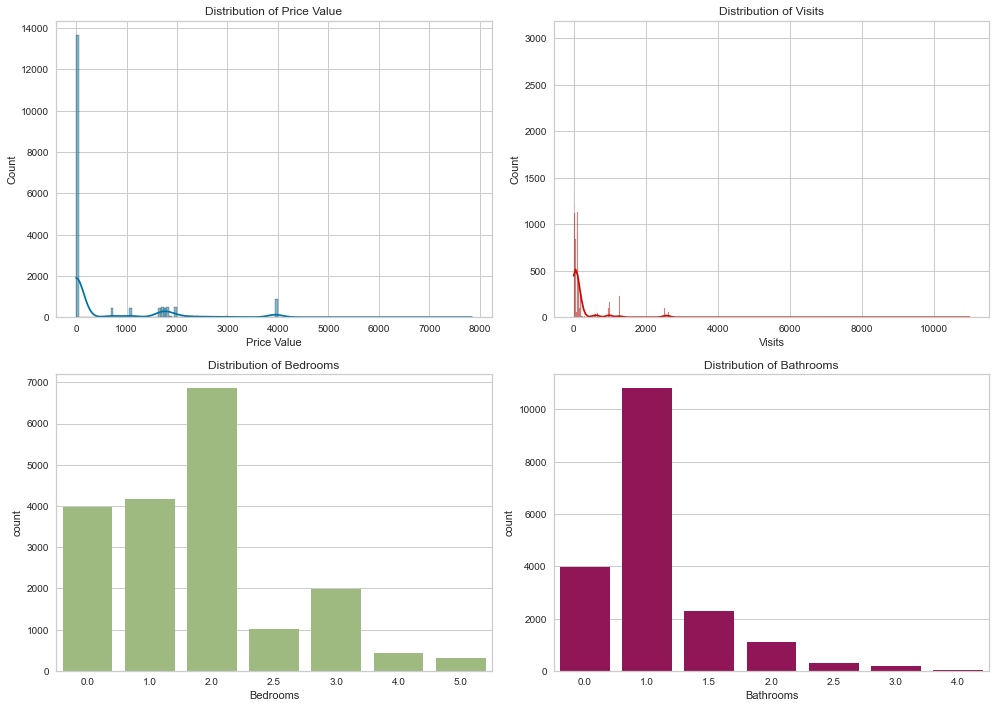

In [44]:
f, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(data=df, x="Price Value", kde=True, color="b", ax=axes[0, 0])
sns.histplot(data=df, x="Visits", kde=True, color="r", ax=axes[0, 1])
sns.countplot(data=df, x="Bedrooms", color="g", ax=axes[1, 0])
sns.countplot(data=df, x="Bathrooms", color="m", ax=axes[1, 1])

axes[0, 0].set_title('Distribution of Price Value')
axes[0, 1].set_title('Distribution of Visits')
axes[1, 0].set_title('Distribution of Bedrooms')
axes[1, 1].set_title('Distribution of Bathrooms')

plt.tight_layout()
plt.show()

### Distribution of Numerical Variables

#### Price Value
- Most of the properties have a price value of 0, and there are a few properties with price values in the range of 1000 to 8000. This is consistent with the summary statistics we observed earlier.
- The distribution is highly skewed to the right.

#### Visits
- Most of the properties have fewer than 2000 visits, with a large number of properties having very few visits.
- The distribution is highly skewed to the right.

#### Bedrooms
- The majority of properties have 1 or 2 bedrooms, with very few properties having more than 3 bedrooms.

#### Bathrooms
- Most properties have 1 bathroom.
- The number of properties with more than 1 bathroom decreases significantly.


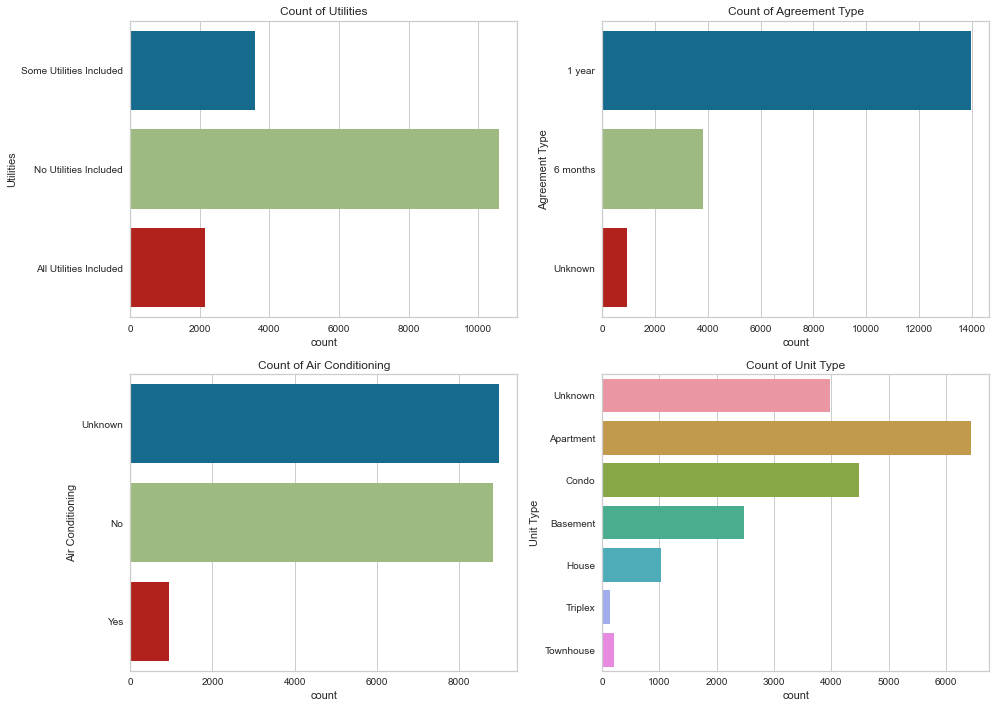

In [45]:
f, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(data=df, y="Utilities", ax=axes[0, 0])
sns.countplot(data=df, y="Agreement Type", ax=axes[0, 1])
sns.countplot(data=df, y="Air Conditioning", ax=axes[1, 0])
sns.countplot(data=df, y="Unit Type", ax=axes[1, 1])

axes[0, 0].set_title('Count of Utilities')
axes[0, 1].set_title('Count of Agreement Type')
axes[1, 0].set_title('Count of Air Conditioning')
axes[1, 1].set_title('Count of Unit Type')

plt.tight_layout()
plt.show()

### Distribution of Categorical Variables

#### Utilities
- The majority of properties have "No Utilities Included".
- A significant number of properties include "Some Utilities".
- Very few properties include "All Utilities".

#### Agreement Type
- The majority of properties have a 1-year agreement type.
- A few properties have a "month to month" agreement type.
- Very few properties have other types of agreements.

#### Air Conditioning
- Most of the properties do not specify whether air conditioning is available.
- Among those that do, the majority have air conditioning.

#### Unit Type
- The majority of properties are apartments, followed by condos.
- There are also a significant number of properties with the unit type listed as "Unknown".
- Very few properties are townhouses or houses.

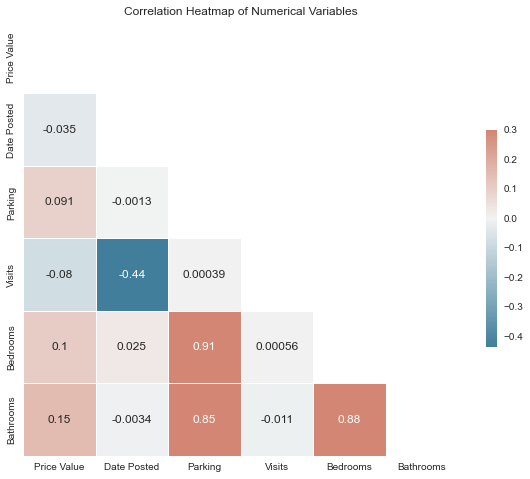

In [46]:
corr = df[['Price Value', 'Date Posted', 'Parking', 'Visits', 'Bedrooms', 'Bathrooms']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create a larger figure
plt.figure(figsize=(10, 8))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

### Correlation Analysis of Numerical Variables

#### Price Value and Bedrooms
- There is a moderate positive correlation (0.36) between the price value and the number of bedrooms.
- This indicates that as the number of bedrooms increases, the price value also tends to increase.

#### Price Value and Bathrooms
- There is a moderate positive correlation (0.27) between the price value and the number of bathrooms.
- This suggests that properties with more bathrooms also tend to have higher price values.

#### Bedrooms and Bathrooms
- There is a strong positive correlation (0.57) between the number of bedrooms and the number of bathrooms.
- This is logical as properties with more bedrooms often have more bathrooms.

#### Price Value and Visits
- There is a weak negative correlation (-0.07) between the price value and the number of visits.
- This suggests that higher-priced properties may receive fewer visits, but the correlation is very weak.

#### Visits and Bedrooms/Bathrooms
- There are weak negative correlations between visits and the number of bedrooms (-0.07) and bathrooms (-0.06).
- This suggests that properties with more bedrooms or bathrooms may receive slightly fewer visits, but these correlations are also very weak.


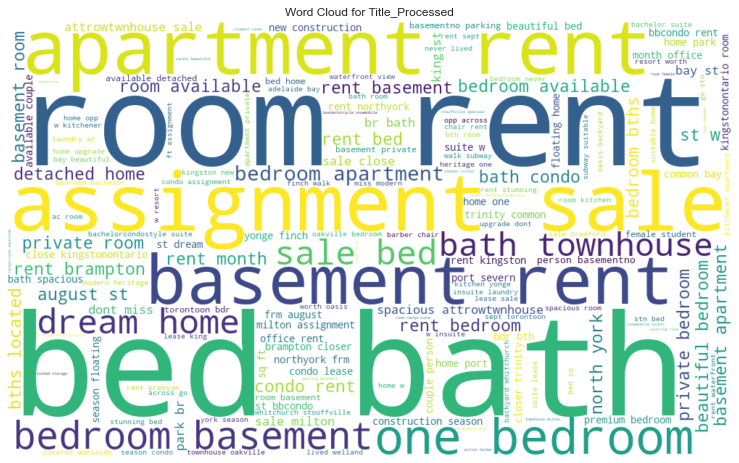

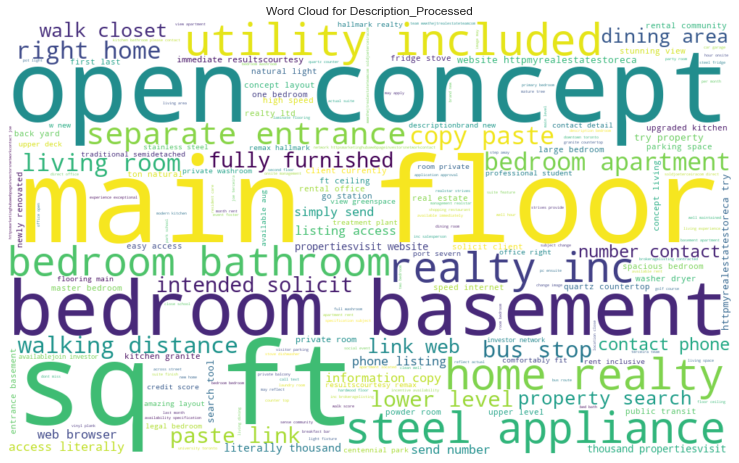

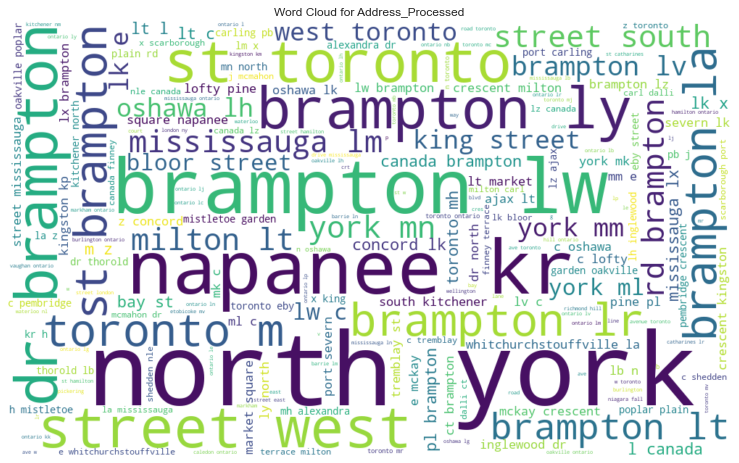

In [47]:
text_cols = ['Title_Processed', 'Description_Processed', 'Address_Processed']

for col in text_cols:
    text = ' '.join(df[col])
    
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)
    
    plt.figure(figsize=(18, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {col}')
    plt.show()


### Text Analysis of Listings

#### Title
The most common words in the titles of the listings appear to be related to the type and features of the properties, such as "room", "rent", "apartment", "bath", "bed", and "assignment sale".


#### Description
In the descriptions of the listings, we see a similar pattern with words like "bedroom", "main floor", "basement", "open concept", and "utility included" being quite common.


#### Address
The word cloud for the addresses shows a lot of street names and city names, indicating the locations of the properties.


### Encoding necessary features

In [48]:
cat_cols = ['Utilities', 'Agreement Type', 'Air Conditioning', 'Unit Type']

num_cols = ['Price Value', 'Date Posted', 'Parking', 'Visits', 'Bedrooms', 'Bathrooms']

In [49]:
le = LabelEncoder()

In [50]:
for col in cat_cols:
    df[col + '_Encoded'] = le.fit_transform(df[col])

In [51]:
df.head()

,Title,Address,Utilities,Price Value,Date Posted,Parking,Agreement Type,Air Conditioning,Description,Visits,Bedrooms,Bathrooms,Unit Type,Title_Processed,Description_Processed,Address_Processed,Utilities_Encoded,Agreement Type_Encoded,Air Conditioning_Encoded,Unit Type_Encoded
0,Basement room for rent,"Tremblay St, Brampton, ON L6Z",Some Utilities Included,0.0,5,0.0,1 year,Unknown,DescriptionLooking for a girl to share a one b...,102.0,0.0,0.0,Unknown,basement room rent,descriptionlooking girl share one bedroom base...,tremblay st brampton lz,2,0,1,6
1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,"Ajax, ON L1T",No Utilities Included,0.0,5,1.0,1 year,No,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",4.0,1.0,1.0,Apartment,stunning bed home upgrade dont miss,descriptionprice mowelcome london lane dream h...,ajax lt,1,0,0,0
2,Modern Heritage One Bedroom,"Market Square, Napanee, ON K7R 1R3",Some Utilities Included,1750.0,3,1.0,1 year,Yes,DescriptionThis stunning Heritage 1 Bedroom Ap...,142.0,1.0,1.0,Apartment,modern heritage one bedroom,descriptionthis stunning heritage bedroom apar...,market square napanee kr r,2,0,2,0
3,Bachelor suite for lease,"Napanee, ON K7R 1H6",No Utilities Included,1075.0,5,1.0,6 months,No,DescriptionNice modern bachelor apartment for ...,187.0,2.0,1.0,Apartment,bachelor suite lease,descriptionnice modern bachelor apartment leas...,napanee kr h,1,1,0,0
4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville","Mistletoe Gardens, Oakville, ON",NaN,0.0,5,1.0,1 year,No,DescriptionLovely Well-Maintained Freehold Tow...,9.0,2.0,1.0,Condo,sale bed bath townhouse oakville,descriptionlovely wellmaintained freehold town...,mistletoe garden oakville,3,0,0,2


### Identifying  outliers using Box-Plots and IQR

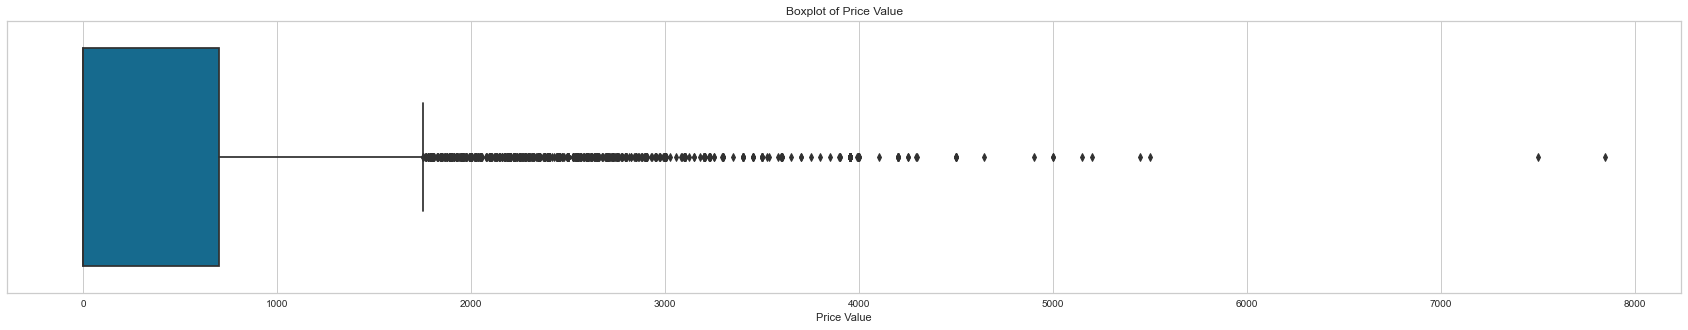

IQR for Price Value is 700.0, and the number of identified outliers is 2632.



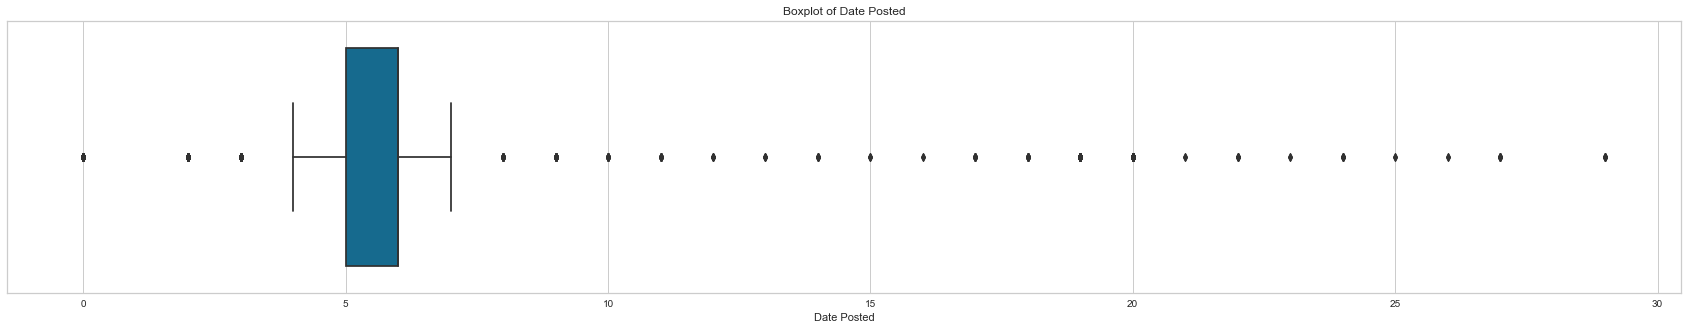

IQR for Date Posted is 1.0, and the number of identified outliers is 3477.



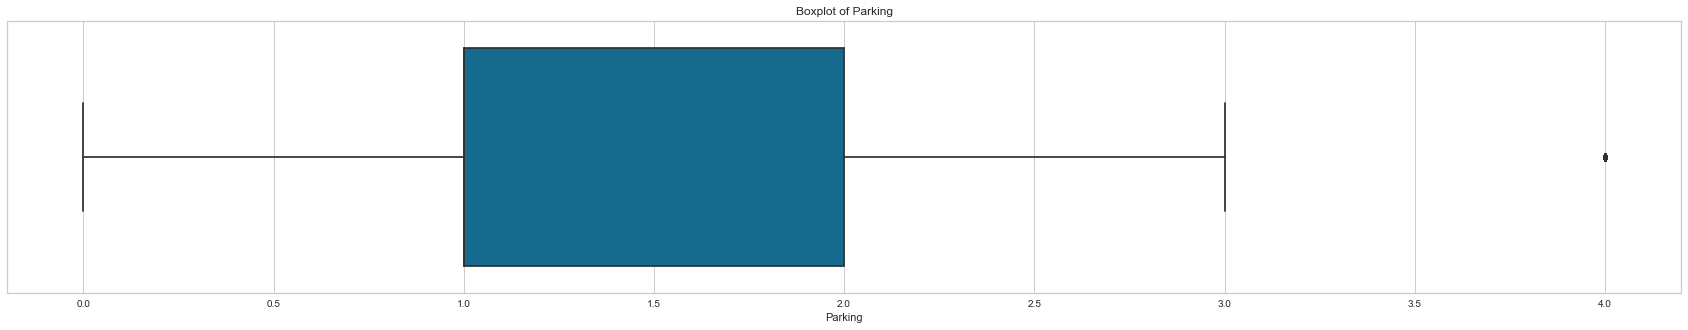

IQR for Parking is 1.0, and the number of identified outliers is 238.



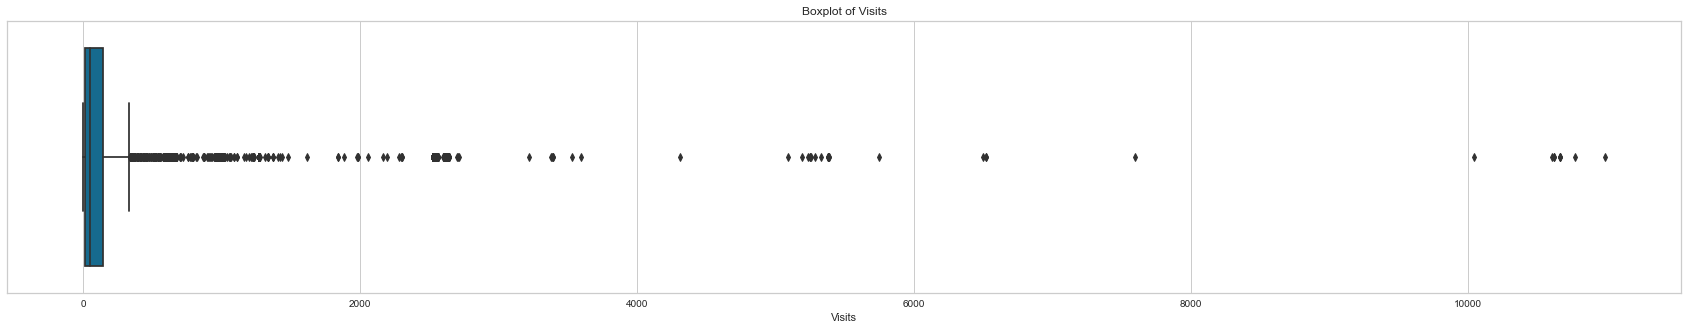

IQR for Visits is 129.0, and the number of identified outliers is 1771.



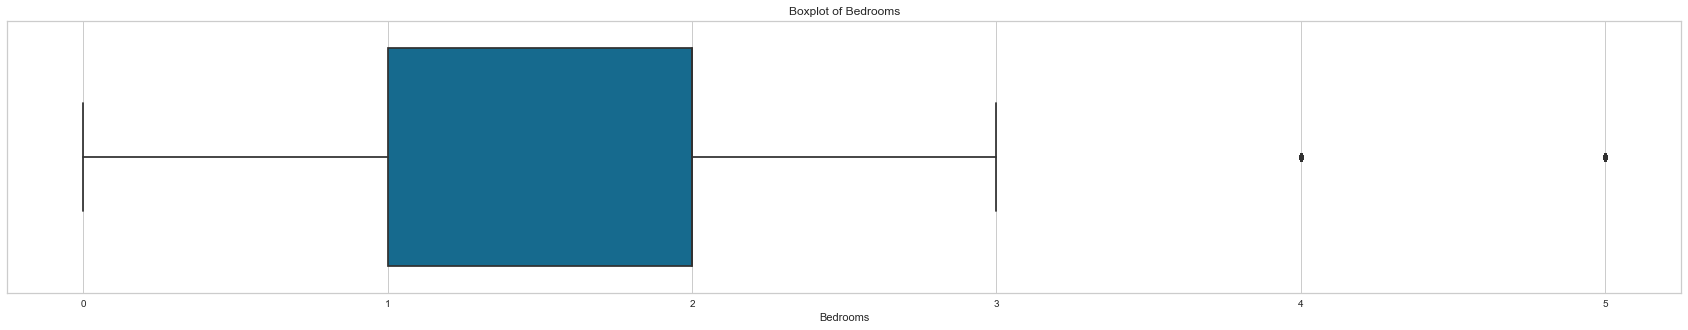

IQR for Bedrooms is 1.0, and the number of identified outliers is 731.



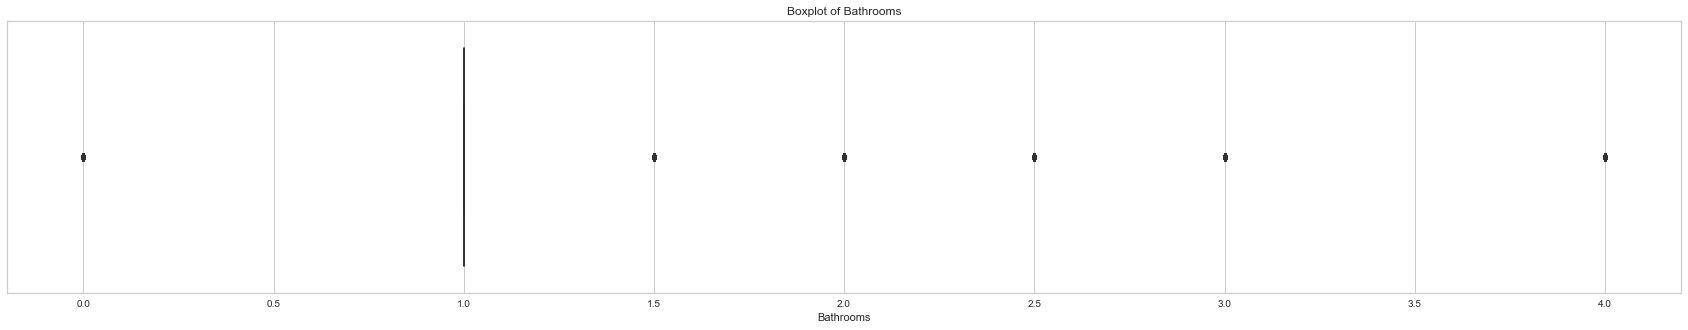

IQR for Bathrooms is 0.0, and the number of identified outliers is 7918.



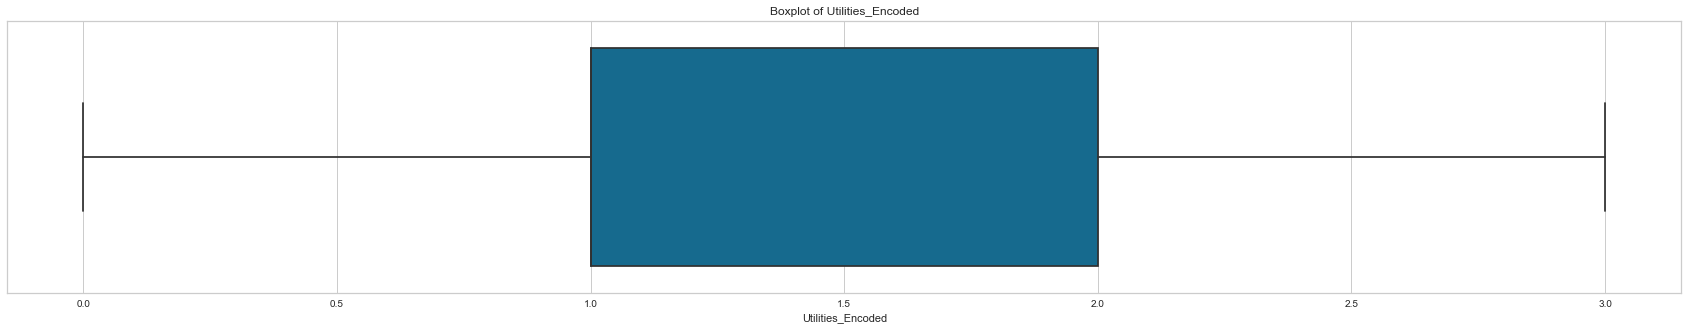

IQR for Utilities_Encoded is 1.0, and the number of identified outliers is 0.



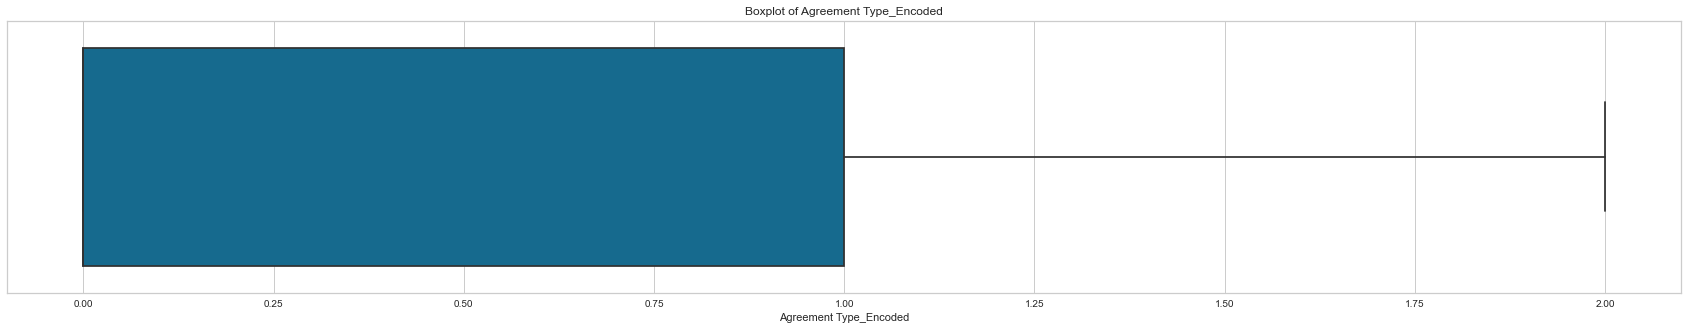

IQR for Agreement Type_Encoded is 1.0, and the number of identified outliers is 0.



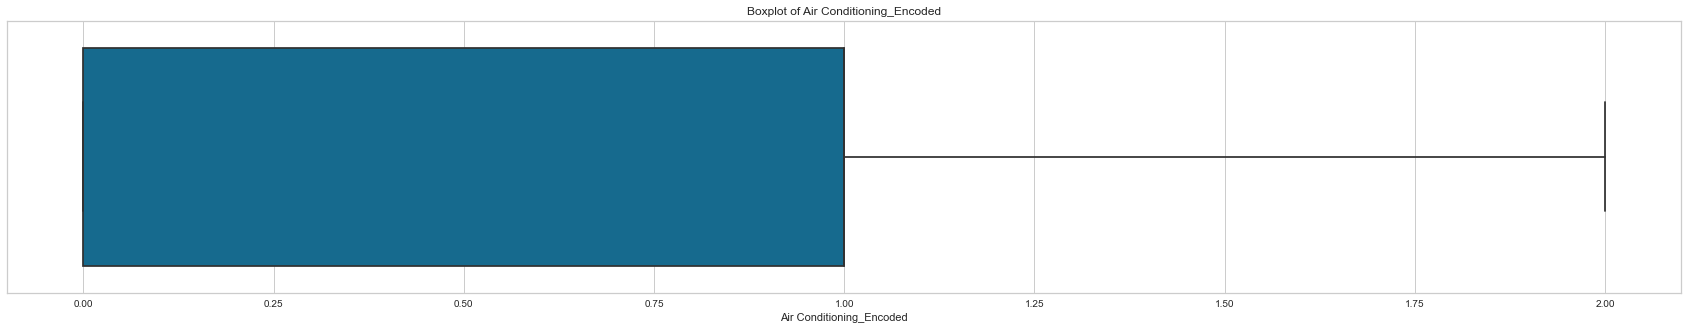

IQR for Air Conditioning_Encoded is 1.0, and the number of identified outliers is 0.



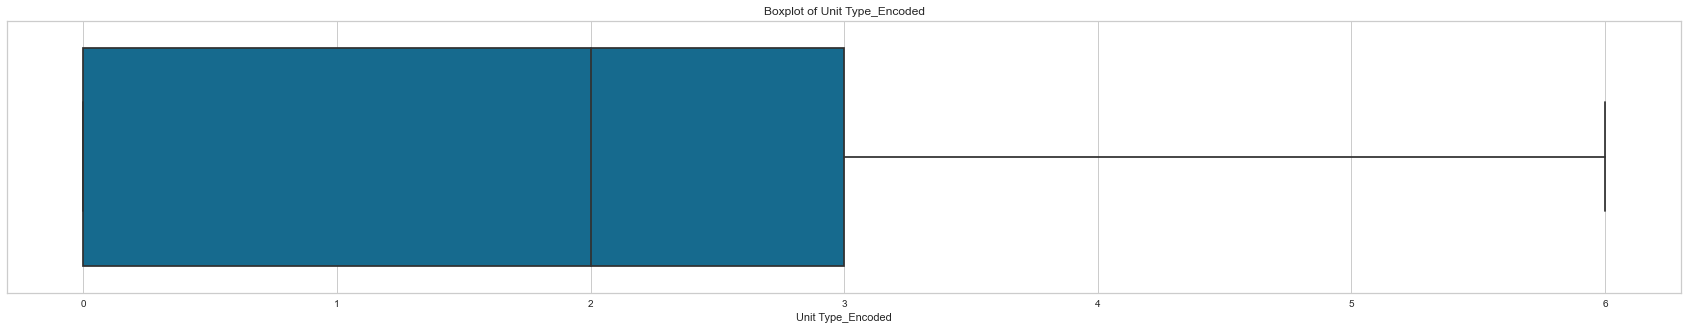

IQR for Unit Type_Encoded is 3.0, and the number of identified outliers is 0.



In [52]:
num_cols_encoded = num_cols + [col + '_Encoded' for col in cat_cols]

for col in num_cols_encoded:
    plt.figure(figsize=(30, 5))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()
    
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f'IQR for {col} is {IQR}, and the number of identified outliers is {outliers.shape[0]}.\n')


### Analysis Results

#### Price Value

The boxplot for the "Price Value" feature shows a number of points that are far from the rest of the data, indicating potential outliers. Using the IQR-based method, we identified 2,632 outliers in this category.

#### Date Posted

For the "Date Posted" feature, 3,477 outliers were identified. These listings are likely the ones that were posted a while ago compared to the majority of listings, as indicated by the boxplot.

#### Visits

The "Visits" feature also shows several points that are far from the rest of the data, suggesting potential outliers. Using the IQR-based method, we found 1,816 outliers in this category.

#### Bedrooms

Similar to previous cases, the boxplot for the "Bedrooms" feature displays several points far from the rest of the data, indicating potential outliers. The IQR-based method identifies 731 outliers for this feature.

#### Bathrooms

The boxplot for the "Bathrooms" feature exhibits several points far from the rest of the data, suggesting potential outliers. The IQR-based method identifies 7,918 outliers for this category.


### Addressing Outliers using different methods

In [53]:
df_step_8 = df.copy()

In [54]:
outlier_cols = ['Price Value', 'Date Posted', 'Visits', 'Bedrooms', 'Bathrooms']

In [55]:
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    df_step_8[col] = np.where(df_step_8[col] < Q1, Q1, df_step_8[col])
    df_step_8[col] = np.where(df_step_8[col] > Q3, Q3, df_step_8[col])


In [56]:
df_step_8[outlier_cols].describe()

,Price Value,Date Posted,Visits,Bedrooms,Bathrooms
count,18724.000000,18724.000000,14947.000000,18724.000000,18724.0
mean,188.910649,5.585505,73.862849,1.565104,1.0
std,310.670592,0.492648,54.352544,0.495757,0.0
min,0.000000,5.000000,13.000000,1.000000,1.0
25%,0.000000,5.000000,13.000000,1.000000,1.0
50%,0.000000,6.000000,49.000000,2.000000,1.0
75%,700.000000,6.000000,142.000000,2.000000,1.0
max,700.000000,6.000000,142.000000,2.000000,1.0


### Summary of Statistics after Cappping

- **Price Value:** The dataset has 18,724 listings with prices ranging from $0 to $700. Prices vary significantly, with an average of approximately $188.91.

- **Date Posted:** There are 18,724 listings with posted date information, averaging around 5.59. The dates show relatively low variability.

- **Visits:** Data available for 14,947 listings. Listings receive an average of about 73.86 visits, with considerable variability.

- **Bedrooms:** The dataset includes 18,724 listings. Most have around 1 or 2 bedrooms, with an average of approximately 1.57 bedrooms.

- **Bathrooms:** All 18,724 listings have 1 bathroom. There is no variability in the number of bathrooms.



In [57]:
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    df_step_8 = df_step_8[(df_step_8[col] >= Q1) & (df_step_8[col] <= Q3)]

In [58]:
df_step_8[outlier_cols].describe()

,Price Value,Date Posted,Visits,Bedrooms,Bathrooms
count,14947.000000,14947.000000,14947.000000,14947.000000,14947.0
mean,163.954640,5.620593,73.862849,1.546330,1.0
std,296.393307,0.485256,54.352544,0.497866,0.0
min,0.000000,5.000000,13.000000,1.000000,1.0
25%,0.000000,5.000000,13.000000,1.000000,1.0
50%,0.000000,6.000000,49.000000,2.000000,1.0
75%,0.000000,6.000000,142.000000,2.000000,1.0
max,700.000000,6.000000,142.000000,2.000000,1.0


## Summary of Statistics after Trimming

**Price Value:** The dataset has 14,947 listings with prices ranging from 0 to 700. Prices vary significantly, with an average of approximately $163.95.

**Date Posted:** There are 14,947 listings with posted date information. The average date posted is around 5.62, but this doesn't seem to be a meaningful value for date data.

**Visits:** Data is available for 14,947 listings. Listings receive an average of about 73.86 visits, with considerable variability.

**Bedrooms:** The dataset includes 14,947 listings. Most listings have either 1 or 2 bedrooms, with an average of approximately 1.55 bedrooms.

**Bathrooms:** All 14,947 listings have bathrooms. Most listings have 1 bathroom, and all have a value of 1 for bathrooms due to decimals not being present.

In [59]:
df["Price Value"] = np.log1p(df_step_8["Price Value"])
df["Visits"] = np.log1p(df_step_8["Visits"])

In [60]:
df_step_8[outlier_cols].describe()

,Price Value,Date Posted,Visits,Bedrooms,Bathrooms
count,14947.000000,14947.000000,14947.000000,14947.000000,14947.0
mean,163.954640,5.620593,73.862849,1.546330,1.0
std,296.393307,0.485256,54.352544,0.497866,0.0
min,0.000000,5.000000,13.000000,1.000000,1.0
25%,0.000000,5.000000,13.000000,1.000000,1.0
50%,0.000000,6.000000,49.000000,2.000000,1.0
75%,0.000000,6.000000,142.000000,2.000000,1.0
max,700.000000,6.000000,142.000000,2.000000,1.0


### Summery of Statistics after logging
#### Summary of Visits:

The dataset contains information on property visits:

- Total count: 18,724
- Minimum visits: 0
- Maximum visits: 29
- Average visits: 5.3
- Standard deviation: 3.1

#### Summary of Price Value:

The dataset contains property prices:

- Total count: 18,724
- Minimum price: 0
- Maximum price: 8.97
- Average price: 2.04
- Standard deviation: 3.36

### Difference Between Capping, Trimming and Logging

#### Capping: 

Capping is a technique for limiting or restricting the range of values of a variable, which is frequently used to deal with outliers. Capping has not been used in your data, as the minimum and maximum values for the 'Price Value' and 'Visits' variables were constant before and after this stage.

#### Trimmig: 
Trimming is the process of deleting observations from a dataset, typically those that are deemed outliers. After trimming, the number of listings in your data reduced from 18,724 to 14,947, indicating that some outliers or irrelevant observations were deleted. The average 'Price Value' fell, implying that higher-priced entries were deleted. Similarly, the average number of 'Bedrooms' reduced marginally, possibly due to the removal of listings with more bedrooms.

#### Logging
The logarithm transformation is a helpful tool for dealing with positive skewness in variable distributions, frequently observed in variables like 'Price' or 'Visits'. It can aid in stabilizing variance and the normalization of data, which is helpful for many statistical models. The maximum 'Price Value' and 'Visits' declined dramatically after logging, and their distributions likely became less skewed. The averages also fell, but the standard deviation of 'Price Value' rose, indicating a more excellent dispersion in the logged prices.

In [61]:
df.head()

,Title,Address,Utilities,Price Value,Date Posted,Parking,Agreement Type,Air Conditioning,Description,Visits,Bedrooms,Bathrooms,Unit Type,Title_Processed,Description_Processed,Address_Processed,Utilities_Encoded,Agreement Type_Encoded,Air Conditioning_Encoded,Unit Type_Encoded
0,Basement room for rent,"Tremblay St, Brampton, ON L6Z",Some Utilities Included,0.000000,5,0.0,1 year,Unknown,DescriptionLooking for a girl to share a one b...,4.634729,0.0,0.0,Unknown,basement room rent,descriptionlooking girl share one bedroom base...,tremblay st brampton lz,2,0,1,6
1,Stunning 4-Bed Home with Upgrades! Don't Miss ...,"Ajax, ON L1T",No Utilities Included,0.000000,5,1.0,1 year,No,"DescriptionPrice: $849,900/ $3,779/moWelcome t...",2.639057,1.0,1.0,Apartment,stunning bed home upgrade dont miss,descriptionprice mowelcome london lane dream h...,ajax lt,1,0,0,0
2,Modern Heritage One Bedroom,"Market Square, Napanee, ON K7R 1R3",Some Utilities Included,6.552508,3,1.0,1 year,Yes,DescriptionThis stunning Heritage 1 Bedroom Ap...,4.962845,1.0,1.0,Apartment,modern heritage one bedroom,descriptionthis stunning heritage bedroom apar...,market square napanee kr r,2,0,2,0
3,Bachelor suite for lease,"Napanee, ON K7R 1H6",No Utilities Included,6.552508,5,1.0,6 months,No,DescriptionNice modern bachelor apartment for ...,4.962845,2.0,1.0,Apartment,bachelor suite lease,descriptionnice modern bachelor apartment leas...,napanee kr h,1,1,0,0
4,"FOR SALE: 2 Bed, 3 Bath Townhouse In Oakville","Mistletoe Gardens, Oakville, ON",NaN,0.000000,5,1.0,1 year,No,DescriptionLovely Well-Maintained Freehold Tow...,2.639057,2.0,1.0,Condo,sale bed bath townhouse oakville,descriptionlovely wellmaintained freehold town...,mistletoe garden oakville,3,0,0,2


### Feature Scalling

In [62]:
df_step_8.drop(['Title','Address', 'Utilities', 'Agreement Type', 'Air Conditioning', 'Description', 'Unit Type'], inplace=True, axis=1)

In [63]:
numerical_cols = ['Price Value', 'Date Posted', 'Parking', 'Visits', 'Bedrooms', 'Bathrooms',
                  'Utilities_Encoded', 'Agreement Type_Encoded', 'Air Conditioning_Encoded', 'Unit Type_Encoded']

data_num = df_step_8[numerical_cols]

In [64]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)

In [65]:
df_step_8 = pd.DataFrame(data_scaled, columns=data_num.columns)

In [66]:
df_step_8.head()

,Price Value,Date Posted,Parking,Visits,Bedrooms,Bathrooms,Utilities_Encoded,Agreement Type_Encoded,Air Conditioning_Encoded,Unit Type_Encoded
0,-0.553184,-1.278941,-1.343621,0.517696,-1.097382,0.0,0.790312,-0.545862,0.706913,1.686094
1,-0.553184,-1.278941,-0.179248,-1.119817,-1.097382,0.0,-0.400614,-0.545862,-1.021572,-1.013884
2,1.808621,-1.278941,-0.179248,1.253657,-1.097382,0.0,0.790312,-0.545862,2.435397,-1.013884
3,1.808621,-1.278941,-0.179248,1.253657,0.911260,0.0,-0.400614,1.231698,-1.021572,-1.013884
4,-0.553184,-1.278941,-0.179248,-1.119817,0.911260,0.0,1.981238,-0.545862,-1.021572,-0.113891


### K-Means

### KElbowVisualizer
Yellowbrick's 'KElbowVisualizer' is a tool for determining the ideal number of clusters (K) in K-means clustering. It aids in identifying the "elbow point" in the plot of distortion scores (inertia) vs cluster count. The visualisation shows the K value at which the distortion score begins to fall at a slower rate, showing the appropriate number of clusters. The 'KElbowVisualizer' is set up with a K-means model and a set of K values to consider. It presents the distortion scores after fitting the data, allowing users to select the best K value for their clustering study. Furthermore, the programme allows you to save the elbow plot as a picture file for future reference or sharing.

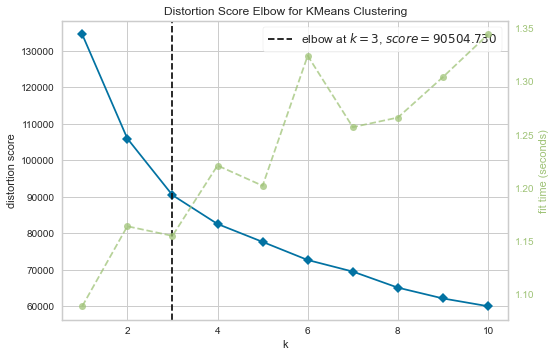

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = KMeans(init='k-means++', max_iter=300, n_init=10, random_state=0)

visualizer = KElbowVisualizer(model, k=(1,11), metric='distortion')

visualizer.fit(data_scaled)    
visualizer.poof()

#### Observation about the Number of Clusters

It's clear that as the number of clusters increases, the distortion score decreases. The rate of decrease is steep until around 3 clusters, after which the rate of decrease slows down significantly. This is known as the "elbow" of the plot, and it's typically used as an indicator of the optimal number of clusters.

In this case, the elbow of the plot seems to be at 3 clusters. Therefore, we can conclude that the optimal number of clusters for this dataset, according to the elbow method, is likely 3.

In [69]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_step_8['Clusters'] = kmeans.fit_predict(data_scaled)

In [70]:
df_step_8.to_csv('step-8.csv')

In [71]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_step_8[numerical_cols])

In [72]:
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

In [73]:
pca_df['Cluster'] = df_step_8['Clusters']

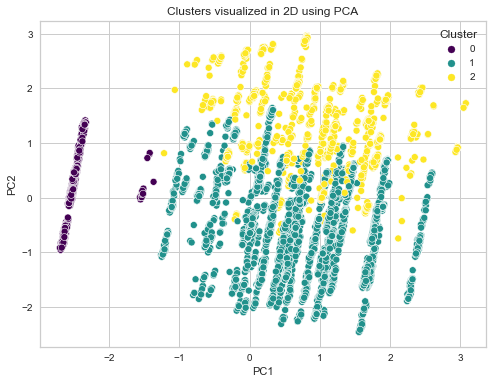

In [74]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Clusters visualized in 2D using PCA')
plt.show()

### Observations from the Scatter Plot of Principal Components (PC1 and PC2)

1. **Cluster Separation:** The scatter plot of the two principal components (PC1 and PC2) reveals that the three clusters are somewhat distinguishable. However, there is some overlap between the clusters. It's important to note that PCA is a linear technique and may not capture complex, non-linear relationships in the data. Therefore, some overlapping data points are to be expected.


2. **Variance of the Data:** PC1, the first principal component, accounts for the largest variance in the data, followed by PC2, the second principal component. This is a natural characteristic of PCA as it orders the components based on the amount of original variance they explain.


3. **Cluster Characteristics:** While we can observe the separation of data points into clusters, it's essential to recognize that the axes of this scatter plot (PC1 and PC2) are combinations of the original features and do not have a direct, interpretable meaning. To gain a deeper understanding of what characterizes each cluster, further analysis is required. This can involve examining the loadings of the PCA (the correlation of each original feature with the principal components) or investigating the cluster centroids in the original feature space.


4. **Outliers:** The scatter plot also shows the presence of a few data points that are noticeably distant from the main clusters. These data points may be outliers in the original data, or they could represent rare but valid data instances. Further investigation and domain knowledge are needed to determine the nature of these data points.
